## 7.6 게이트 순환 신경망(GRU)
- GRU는 게이트 메커니즘이 적용된 RNN 프레임워크의 한 종류이면서 LSTM보다 구조가 간단함.

### 7.6.1 GRU 구조
- GRU는 LSTM에서 사용하는 망각 게이트와 입력 게이트를 하나로 합친 것이며, 별도의 업데이트 게이트로 구성되어 있음.
- 하나의 게이트 컨트롤러가 망각 게이트와 입력 게이트를 모두 제어, 게이트 컨트롤러가 1을 출력하면 망각 게이트는 열리고 입력 게이트는 닫히며, 반대로 0을 출력하면 망각 게이트는 닫히고 입력 게이트는 열림. 즉 이전 기억이 저장될 때마다 단계별 입력은 삭제됨.
- GRU는 출력 게이트가 없어 전체 상태 벡터가 매 단계마다 출력되며, 이전 상태의 어느 부분이 출력될지 제어하는 새로운 게이트 컨트롤러가 별도로 존재
- 망각 게이트:
망각 게이트는 과거 정보를 적당히 초기화시키려는 목적으로 시그모이드 함수를 출력으로 이용하여 (0,1) 값을 이전 은닉층에 곱함. 이전 시점의 은닉층 값에 현 시점의 정보에 대한 가중치를 곱한 것으로 수식은 다음과 같음.

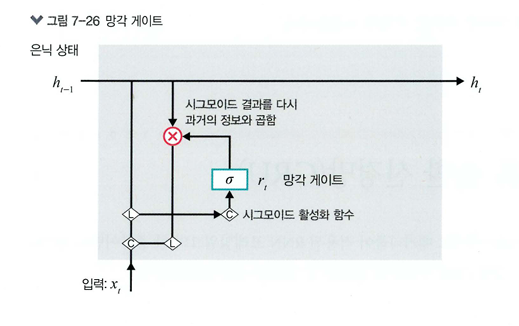

- 업데이트 게이트:
과거와 현재 정보의 최신화 비율을 결정하는 역할을 함.
시그모이드로 출력된 결과는 현 시점의 정보량을 결정하고 1에서 뺀 값을 직전 시점의 은닉층 정보와 곱함.
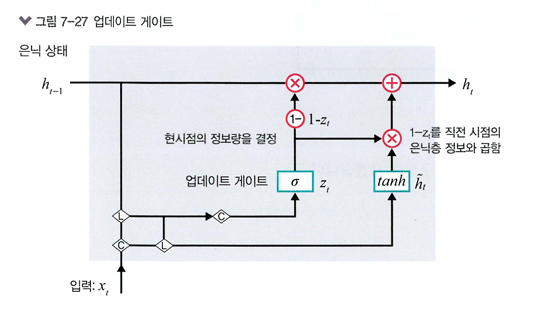

- 후보군: 현시점의 정보에 대한 후보군을 계산, 과거 은닉층의 정보를 그대로 이용하지 않고 망각 게이트의 결과를 이용하여 후보군을 계산

- 은닉층 계산: 마지막으로 업데이트 게이트 결과와 후보군 결과를 결합하여 현시점의 은닉층의 은닉층을 계산, 시그모이드 함수의 결과는 현 시점에서 결과에 대한 정보량을 결정하고, 1-시그모이드 함수의 결과는 과거의 정보량을 결정
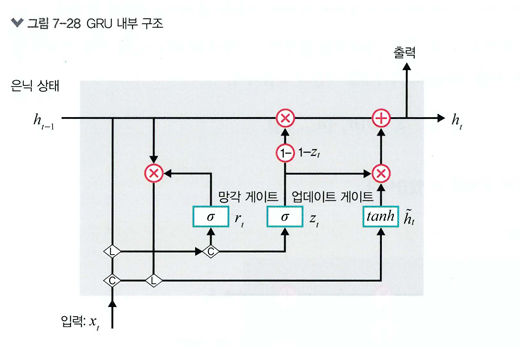


### 7.6.2 GRU 셀 구현


In [ ]:
# 라이브러리 호출
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [ ]:
# 데이터 전처리
mnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

In [ ]:
# 데이터셋 내려받기 및 전처리 적용
from torchvision.datasets import MNIST
download_root = '../chap07/MNIST_DATASET'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 35.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.01MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.66MB/s]


In [ ]:
# 데이터셋 메모리로 가져오기
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True) # 일반적으로 검증과 테스트 용도의 데이터셋은 섞어서 사용하지 않는다. 그러나 여기서는 True로 시정
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# 변수 값 설정
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [ ]:
# GRU 셀 네트워크
class GRUCell(nn.Module):
  def __init__(self, input_size, hidden_size, bias=True):
    super(GRUCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias) # LSTM 셀에서는 4개를 곱했지만 GRU 셀에서는 세개의 게이트가 사용되므로 3을 곱한다.
    self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)
    self.reset_parameters()

  def reset_parameters(self): # 파라미터를 초기화
    std = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-std, std)

  def forward(self, x, hidden):
    x = x.view(-1, x.size(1))

    gate_x = self.x2h(x) # LSTM 셀에서는 gates를 x2h+h2h로 정의했지만 GRU 셀에서는 개별적인 상태를 유지한다.
    gate_h = self.h2h(hidden)
    gate_x = gate_x.squeeze()
    gate_h = gate_h.squeeze()

    i_r, i_i, i_n = gate_x.chunk(3, 1) # 총 세 개의 게이트를 위해 세개로 쪼갠다.
    h_r, h_i, h_n = gate_h.chunk(3, 1)

    resetgate = F.sigmoid(i_r + h_r)
    inputgate = F.sigmoid(i_i + h_i)
    newgate = F.tanh(i_n + (resetgate * h_n)) # 새로운 게이트는 탄젠트 활성화 함수가 적용된 게이트

    hy = newgate + inputgate * (hidden - newgate)
    return hy

In [ ]:
# 전반적인 네트워크 구조
class GRUModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
    super(GRUModel, self).__init__()
    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim

    self.gru_cell = GRUCell(input_dim, hidden_dim, layer_dim) # 앞에서 정의한 GRUCell 함수를 불러온다.
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    if torch.cuda.is_available():
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
    else:
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

    outs = []
    hn = h0[0,:,:] # LSTM 셀에서는 셀 상태에 대해서도 정의했었지만 GRU 셀에서는 셀은 사용되지 않는다.

    for seq in range(x.size(1)):
      hn = self.gru_cell(x[:,seq,:], hn)
      outs.append(hn)
    out = outs[-1].squeeze()
    out = self.fc(out)
    return out

In [ ]:
# 옵티마이저와 손실 함수 설정
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)

if torch.cuda.is_available():
  model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# 모델 학습 및 성능 검증
seq_dim = 28
loss_list = []
iter = 0
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    if torch.cuda.is_available():
      images = Variable(images.view(-1, seq_dim, input_dim).cuda())
      labels = Variable(labels.cuda())
    else:
      images = Variable(images.view(-1, seq_dim, input_dim))
      labels = Variable(labels)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)

    if torch.cuda.is_available():
      loss.cuda()

    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())
    iter += 1

    if iter % 500 == 0:
      correct = 0
      total = 0
      for images, labels in valid_loader:
        if torch.cuda.is_available():
          images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
          images = Variable(images.view(-1, seq_dim, input_dim))

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        if torch.cuda.is_available():
          correct += (predicted.cpu() == labels.cpu()).sum()
        else:
          correct += (predicted == labels).sum()

      accuracy = 100 * correct / total
      print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.6616928577423096. Accuracy: 43.59000015258789
Iteration: 1000. Loss: 0.8945668935775757. Accuracy: 76.19999694824219
Iteration: 1500. Loss: 0.29147759079933167. Accuracy: 89.7300033569336
Iteration: 2000. Loss: 0.23627907037734985. Accuracy: 93.51000213623047
Iteration: 2500. Loss: 0.03288722783327103. Accuracy: 95.05000305175781
Iteration: 3000. Loss: 0.030374936759471893. Accuracy: 95.81999969482422
Iteration: 3500. Loss: 0.1621057391166687. Accuracy: 96.33999633789062
Iteration: 4000. Loss: 0.19308771193027496. Accuracy: 96.19000244140625
Iteration: 4500. Loss: 0.05172014236450195. Accuracy: 97.0
Iteration: 5000. Loss: 0.13900171220302582. Accuracy: 97.26000213623047
Iteration: 5500. Loss: 0.08090294897556305. Accuracy: 97.62000274658203
Iteration: 6000. Loss: 0.10488354414701462. Accuracy: 97.69000244140625
Iteration: 6500. Loss: 0.07984036952257156. Accuracy: 97.80000305175781
Iteration: 7000. Loss: 0.10250388830900192. Accuracy: 97.55999755859375
Iteration

- LSTM 셀을 실행했을 떄의 정확도와 유사
- 주어진 데이터셋을 다양한 모델에 적용하여 최적의 모델을 찾는 것이 중요

In [ ]:
# 테스트 데이터셋을 이용한 모델 예측
def evaluate(model, val_iter):
  corrects, total, total_loss = 0, 0, 0
  model.eval()
  for images, labels in val_iter:
    if torch.cuda.is_available():
      images = Variable(images.view(-1, seq_dim, input_dim).cuda())
    else:
      images = Variable(images.view(-1, seq_dim, input_dim)).to(device)

    logit = model(images).to(device)
    loss = F.cross_entropy(logit, labels, reduction='sum')
    _, predicted = torch.max(logit.data, 1)
    total += labels.size(0)
    total_loss += loss.item()
    corrects += (predicted == labels).sum()

  avg_loss = total_loss / len(val_iter.dataset)
  avg_accuracy = corrects / total
  return avg_loss, avg_accuracy

In [ ]:
# 모델 예측 결과
test_loss, test_acc = evaluate(model, test_loader)
print('Test Loss: %5.2f | Test Accuracy: %5.2f' % (test_loss, test_acc))

Test Loss:  0.07 | Test Accuracy:  0.98


## 7.6.3 GRU 계층 구현

In [1]:
# 라이브러리 호출
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving SBUX.csv to SBUX.csv


In [3]:
data = pd.read_csv('SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

In [5]:
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [6]:
# 훈련과 테스트 데이터셋 정규화
ms = MinMaxScaler()
ss = StandardScaler()
X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200,:]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [7]:
# 데이터셋 형태 변경
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                    1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                  1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [8]:
# GRU 모델의 네트워크
class GRU(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(GRU, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length

    self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc_1 = nn.Linear(hidden_size, 128)
    self.fc = nn.Linear(128, num_classes)
    self.relu = nn.ReLU()

  def forward(self, x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 은닉 상태에 대해 0으로 초기화하는 부분으로, LSTM 계층은 셀 상태가 있었지만 GRU는 셀 상태를 정의하지 않는다.
    output, (hn) = self.gru(x, (h_0))
    hn = hn.view(-1, self.hidden_size)
    out = self.relu(hn)
    out = self.fc_1(out)
    out = self.relu(out)
    out = self.fc(out)
    return out

In [9]:
# 옵티마이저와 손실 함수 지정
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1 # GRU 계층의 개수

num_classes = 1
model = GRU(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# 모델 학습
for epoch in range(num_epochs):
  outputs = model.forward(X_train_tensors_f)
  optimizer.zero_grad()
  loss = criterion(outputs, y_train_tensors)
  loss.backward()

  optimizer.step()
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.12281
Epoch: 100, loss: 0.04171
Epoch: 200, loss: 0.03076
Epoch: 300, loss: 0.02540
Epoch: 400, loss: 0.02116
Epoch: 500, loss: 0.01913
Epoch: 600, loss: 0.01839
Epoch: 700, loss: 0.01810
Epoch: 800, loss: 0.01796
Epoch: 900, loss: 0.01786


In [11]:
# 그래프 출력을 위한 전처리
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

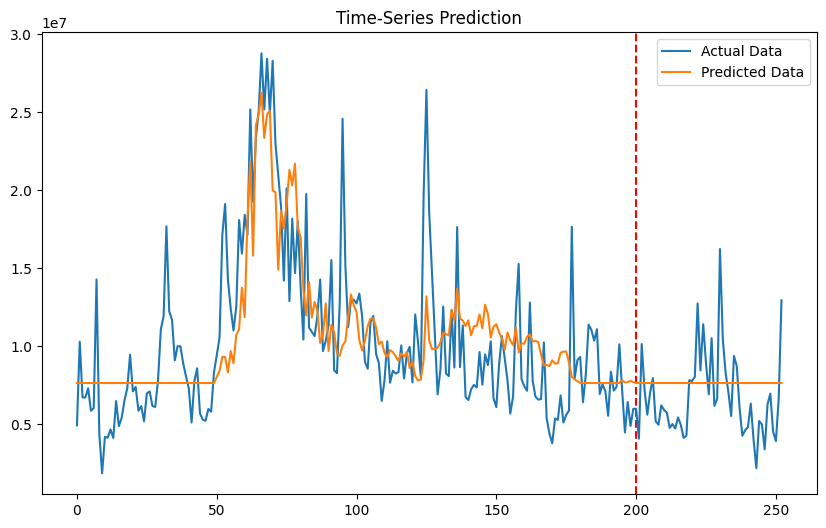

In [12]:
# 모델 예측 결과 출력
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

## 7.7 양방향 RNN
- RNN은 이전 시점의 데이터들을 참고해서 정답을 예측하지만, 실제 문제에서는 과거 시점이 아닌 미래 시점의 데이터에 힌트가 있는 경우도 많음. 따라서 이전 시점의 데이터뿐만 아니라, 이후 시점의 데이터도 함께 활용해 출력 값을 예측하고자 하는 것임.

### 7.7.1 양방향 RNN 구조
- 양방향 RNN은 하나의 출력 값을 예측하는 데 메모리 셀 두개를 사용, 첫 번쨰 메모리 셀은 이전 시점의 은닉 상태를 전달받아 현재의 은닉 상태를 계산
- 두 번째 메모리 셀은 다음 시점의 은닉 상태를 전달받아 현재의 은닉 상태를 계산
- 이 값 두개를 모두 출력층에서 출력 값을 예측하는 데 사용

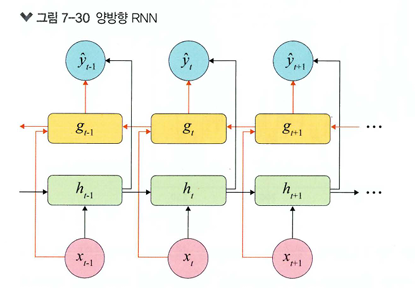


### 7.7.2 양방향 LSTM 구현


In [13]:
# 모델을 생성하고 학습
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data = pd.read_csv('SBUX.csv')
print(data.dtypes)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]

ms = MinMaxScaler()
ss = StandardScaler()
X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]
y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                    1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                  1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [14]:
# 모델의 네트워크
class biLSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(biLSTM, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                        num_layers=num_layers, bidirectional=True, batch_first=True) # bidirectional=True를 사용하여 양방향 LSTM을 사용.
    self.fc = nn.Linear(hidden_size*2, num_classes) # 입력 데이터가 전방향과 역방향 학습에 모두 전달되며 그 결과들도 모두 출력에 반영된다.
                                                    # 한번 학습하는 데 두개의 계층이 필요하기 때문에 은닉 상태, 셀 상태에 2를 곱하고 마지막 출력층에도 2를 곱해야한다.
    self.relu = nn.ReLU()

  def forward(self, x):
    h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)) #
    c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)) #
    out, _ = self.lstm(x, (h_0, c_0))
    out = self.fc(out[:, -1, :]) # 마지막 시간(time step상 마지막 단계)의 은닉 상태
    out = self.relu(out)
    return out


1. LSTM 계층을 정의하는 부분(nn.LSTM)에 bidirectional=True 옵션을 사용하면 양방향 LSTM을 사용하겠다는 의미로 옵션 변경만으로 손쉽게 구현할 수 있었음, bidirectional=True 옵션은 양방향 RNN, 양방향 GRU 모두에 해당

2. 입력 데이터가 전방향과 역방향 학습에 모두 전달되며 그 결과들도 모두 출력에 반영됨. 즉 한 번 학습하는 데 두개의 계층이 필요하기 때문에 LSTM과는 다르게 은닉 상태, 셀 상태에 2를 곱하고 마지막 출력층에도 2를 곱해야 함.

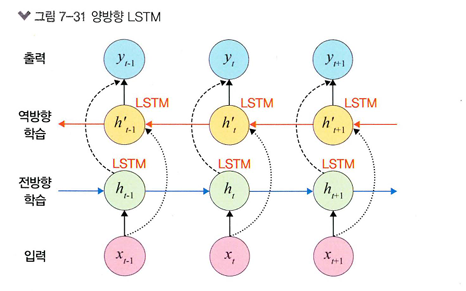

In [15]:
# 모델 학습
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1
num_classes = 1
model = biLSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  outputs = model.forward(X_train_tensors_f)
  optimizer.zero_grad()

  loss = criterion(outputs, y_train_tensors)
  loss.backward()
  optimizer.step()
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.13985
Epoch: 100, loss: 0.13742
Epoch: 200, loss: 0.13490
Epoch: 300, loss: 0.13244
Epoch: 400, loss: 0.13018
Epoch: 500, loss: 0.12834
Epoch: 600, loss: 0.12684
Epoch: 700, loss: 0.12520
Epoch: 800, loss: 0.12278
Epoch: 900, loss: 0.11580


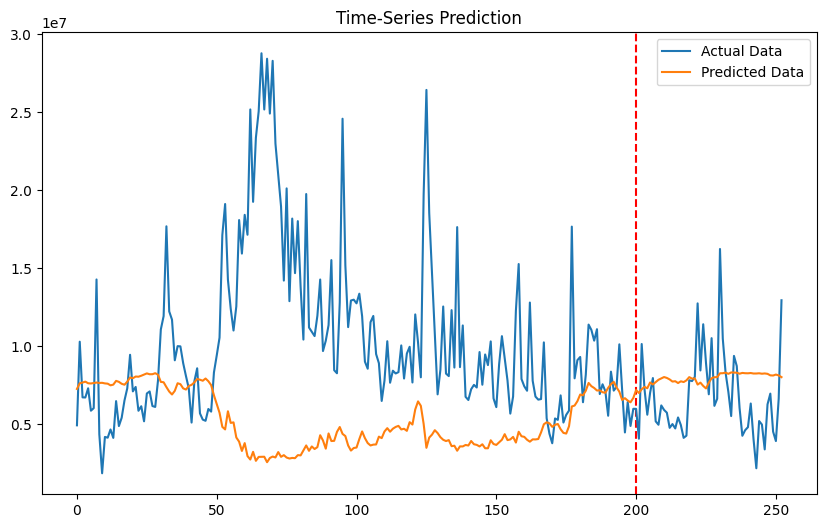

In [16]:
# 모델 평가
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

- LSTM과 비교했을 때 좋은 예측 결과를 보임.